The purpose of this file is to calculate RSCU values for codons in a given sequence, optionally using a sliding window approach and considering cleavage sites. It includes functionality to visualize the RSCU values and filter them based on variance thresholds.

In [16]:
import sys
import os

# Add the directory containing your modules to Python path
sys.path.append('/Users/ellateasell/Research/CodonUsageBias/code')

from Bio import SeqIO
from rscu.rscu_methods import run_rscu_analysis, rscu_to_string
from rscu import PROJ_DIR 
import pandas as pd
import numpy as np
from lib.aminoacids import AA_TO_CODONS_MULTI_CODON_FAMILIES, SLOW, FAST

In [24]:
############ Variables ###########

# Note that the distance variable (d_aa) can be set for each sequence individually when external data is available
# Here we set a default value for all sequences
# The cell below builds an array from this default value, but this can be replaced with an array built from external data

w_aa = 10  # window size in amino acids
d_aa = 20  # distance from cleavage site in amino acids
UseCs = True # when true, we measure the window as the distance from the cleavage site, otherwise from start codon
UseSpAsWindow = False # when true, the window we extract is only the SP region, not a fixed window size

In [25]:
######### Using windows and complements ############

# adjust for nucleotides
w_n = int(w_aa*3) # window size in nucleotides
d_n = int(d_aa*3) # distance from cleavage site in nucleotides

# load SP ORFS (genomic)
all_fasta_path = PROJ_DIR / 'data/filtered/dna_filtered.fasta'
records = list(SeqIO.parse(all_fasta_path, 'fasta'))

# load SP data
tsv_path = PROJ_DIR / 'data/filtered/sp_regions_filtered.tsv'
df = pd.read_table(tsv_path, index_col='sys_name')

# build numpy array of cleavage site values corresponding to the ordering of records
arr_cs_aa = np.zeros(len(records))
for i, record in enumerate(records):
    row = df.loc[record.id]
    arr_cs_aa[i] = row['cs'] if UseCs else 0
arr_cs_n = arr_cs_aa * 3

# build numpy array of npet values, can be loaded with external data when available
arr_npet_n = np.full(len(records), d_n, dtype=int) # set using distance variable above for now

max_len = max(len(record.seq) for record in records)
min_len = min(len(record.seq) for record in records)
print(f"Min length of records: {min_len}")
print(f"Max length of records: {max_len}")

max_cs = df['cs'].max()
min_cs = df['cs'].min()
print(f"Max cleavage site: {max_cs}")
print(f"Min cleavage site: {min_cs}")

window_rscu, full_rscu = run_rscu_analysis(records, arr_cs_n, arr_npet_n, w_n, UseCs, UseSpAsWindow)

print("RSCU values for window:")
print(rscu_to_string(window_rscu))
print("RSCU values for complement ORF:")
print(rscu_to_string(full_rscu))
    

Min length of records: 240
Max length of records: 5409
Max cleavage site: 38.0
Min cleavage site: 16.0
RSCU values for window:
GCT: 1.58
GCC: 1.01
GCA: 1.09
GCG: 0.33
CGT: 0.81
CGC: 0.24
CGA: 0.32
CGG: 0.32
AGA: 3.49
AGG: 0.81
AAT: 1.16
AAC: 0.84
GAT: 1.37
GAC: 0.63
TGT: 1.45
TGC: 0.55
CAA: 1.57
CAG: 0.43
GAA: 1.39
GAG: 0.61
GGT: 2.22
GGC: 0.77
GGA: 0.47
GGG: 0.54
CAT: 1.09
CAC: 0.91
ATT: 1.10
ATC: 1.15
ATA: 0.76
TTA: 1.70
TTG: 2.05
CTT: 0.93
CTC: 0.31
CTA: 0.46
CTG: 0.54
AAA: 1.30
AAG: 0.70
TTT: 1.10
TTC: 0.90
CCT: 0.88
CCC: 0.51
CCA: 1.85
CCG: 0.76
TCT: 1.76
TCC: 1.29
TCA: 1.18
TCG: 0.48
AGT: 0.91
AGC: 0.38
ACT: 1.58
ACC: 0.97
ACA: 1.08
ACG: 0.37
TAT: 0.77
TAC: 1.23
GTT: 1.89
GTC: 0.77
GTA: 0.77
GTG: 0.58
RSCU values for complement ORF:
GCT: 1.67
GCC: 0.99
GCA: 0.99
GCG: 0.36
CGT: 0.93
CGC: 0.36
CGA: 0.37
CGG: 0.26
AGA: 2.90
AGG: 1.18
AAT: 1.07
AAC: 0.93
GAT: 1.24
GAC: 0.76
TGT: 1.34
TGC: 0.66
CAA: 1.40
CAG: 0.60
GAA: 1.41
GAG: 0.59
GGT: 1.96
GGC: 0.78
GGA: 0.83
GGG: 0.43
CAT: 1.23
C

In [26]:
# RSCU values to numpy arrays

rscu_w = np.array(list(window_rscu.values()))
rscu_b = np.array(list(full_rscu.values()))

codons = list(window_rscu.keys())

diffs = rscu_w - rscu_b
avg_diffs = np.mean(diffs)

ratios = rscu_w / rscu_b
avg_ratios = np.mean(ratios)

print("Sanity check...")
print(f"    Average difference: {avg_diffs:.3f}")
print(f"    Average ratio: {avg_ratios:.3f}")

print("Differences between window and complement ORF RSCU values (window - background):")
for codon, diff in zip(codons, diffs): 
    print(f"{codon}: {diff:.3f}")

Sanity check...
    Average difference: 0.000
    Average ratio: 0.987
Differences between window and complement ORF RSCU values (window - background):
GCT: -0.088
GCC: 0.019
GCA: 0.103
GCG: -0.034
CGT: -0.119
CGC: -0.121
CGA: -0.047
CGG: 0.062
AGA: 0.588
AGG: -0.365
AAT: 0.091
AAC: -0.091
GAT: 0.133
GAC: -0.133
TGT: 0.116
TGC: -0.116
CAA: 0.165
CAG: -0.165
GAA: -0.016
GAG: 0.016
GGT: 0.258
GGC: -0.010
GGA: -0.360
GGG: 0.113
CAT: -0.138
CAC: 0.138
ATT: -0.320
ATC: 0.288
ATA: 0.032
TTA: 0.168
TTG: 0.257
CTT: 0.158
CTC: -0.074
CTA: -0.422
CTG: -0.088
AAA: 0.167
AAG: -0.167
TTT: 0.001
TTC: -0.001
CCT: -0.265
CCC: -0.102
CCA: -0.030
CCG: 0.397
TCT: -0.013
TCC: 0.217
TCA: -0.028
TCG: -0.004
AGT: 0.038
AGC: -0.210
ACT: 0.101
ACC: -0.067
ACA: 0.026
ACG: -0.059
TAT: -0.252
TAC: 0.252
GTT: 0.357
GTC: -0.250
GTA: 0.006
GTG: -0.113


In [27]:
############# Analyze by codon family #############

VARIANCE_THRESHOLD = 0.03

aa_codon_dict = {
    aa: {codon: 0 for codon in codons_lst}
    for aa, codons_lst in AA_TO_CODONS_MULTI_CODON_FAMILIES.items()
}

for i in range(len(codons)):
    codon = codons[i]
    diff = diffs[i]
    for aa, codons_lst in AA_TO_CODONS_MULTI_CODON_FAMILIES.items():
        if codon in codons_lst:
            aa_codon_dict[aa][codon] = diff
     
variances = {aa: np.var(list(codon_family.values())) for aa, codon_family in aa_codon_dict.items()}
print("Variance of differences by amino acid:")
for aa, var in variances.items():
    print(f"{aa}: {var:.3f}")
                
print("Differences by amino acid:")
for aa, codon_family in aa_codon_dict.items():
    print(f"{aa}:")
    for codon, diff in codon_family.items():
        print(f"  {codon}: {diff:.3f}")
    var = np.var(list(codon_family.values()))
    print(f"  Sum: {sum(codon_family.values()):.3f}")
    print(f"  Variance: {var:.3f}")
    
    
##### filter codon list for the scatterplot by family variance threshold
varied_aa = [aa for aa, var in variances.items() if var >= VARIANCE_THRESHOLD]
print(f"Amino acids with variance >= {VARIANCE_THRESHOLD}: {varied_aa}")

filtered_w = []
filtered_b = []
filtered_codons = []
for aa in varied_aa:
    for codon, diff in aa_codon_dict[aa].items():
        i = codons.index(codon)
        filtered_w.append(rscu_w[i])
        filtered_b.append(rscu_b[i])
        filtered_codons.append(codon)
        
filtered_b = np.array(filtered_b)
filtered_w = np.array(filtered_w)



Variance of differences by amino acid:
A: 0.005
R: 0.086
N: 0.008
D: 0.018
C: 0.014
Q: 0.027
E: 0.000
G: 0.052
H: 0.019
I: 0.062
L: 0.052
K: 0.028
F: 0.000
P: 0.060
S: 0.016
T: 0.005
Y: 0.063
V: 0.051
Differences by amino acid:
A:
  GCT: -0.088
  GCC: 0.019
  GCA: 0.103
  GCG: -0.034
  Sum: 0.000
  Variance: 0.005
R:
  CGT: -0.119
  CGC: -0.121
  CGA: -0.047
  CGG: 0.062
  AGA: 0.588
  AGG: -0.365
  Sum: -0.000
  Variance: 0.086
N:
  AAT: 0.091
  AAC: -0.091
  Sum: 0.000
  Variance: 0.008
D:
  GAT: 0.133
  GAC: -0.133
  Sum: 0.000
  Variance: 0.018
C:
  TGT: 0.116
  TGC: -0.116
  Sum: -0.000
  Variance: 0.014
Q:
  CAA: 0.165
  CAG: -0.165
  Sum: 0.000
  Variance: 0.027
E:
  GAA: -0.016
  GAG: 0.016
  Sum: 0.000
  Variance: 0.000
G:
  GGT: 0.258
  GGC: -0.010
  GGA: -0.360
  GGG: 0.113
  Sum: 0.000
  Variance: 0.052
H:
  CAT: -0.138
  CAC: 0.138
  Sum: 0.000
  Variance: 0.019
I:
  ATT: -0.320
  ATC: 0.288
  ATA: 0.032
  Sum: -0.000
  Variance: 0.062
L:
  TTA: 0.168
  TTG: 0.257
  CTT: 0

In [28]:

colours = ['k'] * len(codons)

for codon in SLOW:
    index = codons.index(codon)
    colours[index] = 'r' # slow codon
    
for codon in FAST:
    index = codons.index(codon)
    colours[index] = 'b'  # fast codon
    


filtered_colours = ['k'] * len(filtered_codons)

for codon in SLOW:
    if codon not in filtered_codons:
        continue
    index = filtered_codons.index(codon)
    filtered_colours[index] = 'r' # slow codon
    
for codon in FAST:
    if codon not in filtered_codons:
        continue
    index = filtered_codons.index(codon)
    filtered_colours[index] = 'b'  # fast codon

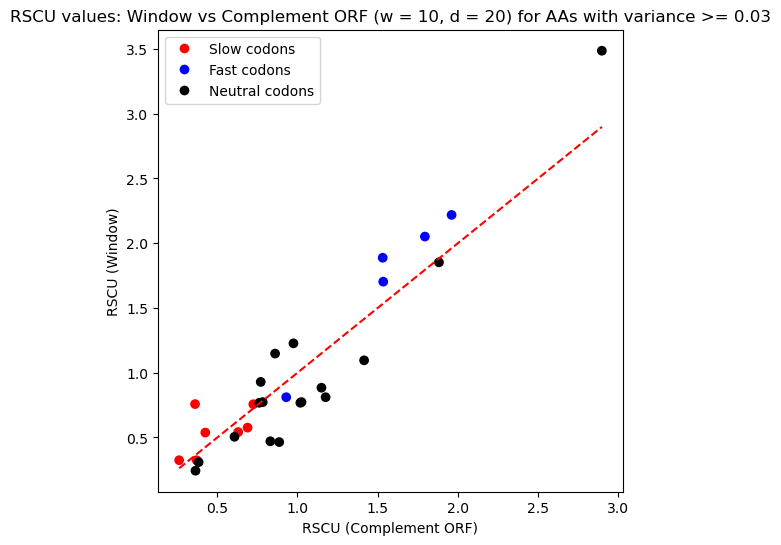

In [29]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


plt.figure(figsize=(6, 6))
plt.scatter(filtered_b, filtered_w, c = filtered_colours)
plt.xlabel('RSCU (Complement ORF)')
plt.ylabel('RSCU (Window)')
if UseSpAsWindow is False:
    plt.title(f'RSCU values: Window vs Complement ORF (w = {w_aa}, d = {d_aa}) for AAs with variance >= {VARIANCE_THRESHOLD}')
else:   
    plt.title(f'RSCU values: SP vs Complement ORF for AAs with variance >= {VARIANCE_THRESHOLD}')
plt.plot([min(rscu_b), max(rscu_b)], [min(rscu_b), max(rscu_b)], 'r--')

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Slow codons'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Fast codons'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='Neutral codons')]

plt.legend(handles=legend_elements, loc='upper left')
plt.show()

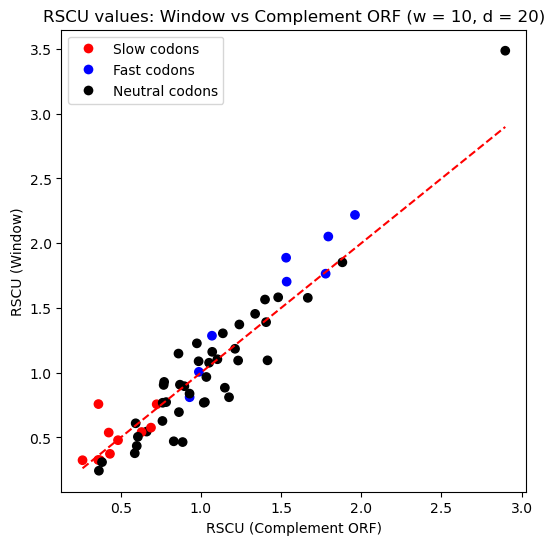

In [30]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


plt.figure(figsize=(6, 6))
plt.scatter(rscu_b, rscu_w, c = colours)
plt.xlabel('RSCU (Complement ORF)')
plt.ylabel('RSCU (Window)')
if UseSpAsWindow is False:
    plt.title(f'RSCU values: Window vs Complement ORF (w = {w_aa}, d = {d_aa})')
else:   
    plt.title(f'RSCU values: SP vs Complement ORF')
plt.plot([min(rscu_b), max(rscu_b)], [min(rscu_b), max(rscu_b)], 'r--')
# Create custom legend elements
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Slow codons'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Fast codons'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='Neutral codons')]

plt.legend(handles=legend_elements, loc='upper left')
plt.show()